In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from pclib.utils.customdataset import PreloadedDataset
import os
import matplotlib.pyplot as plt
%matplotlib inline  
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

In [2]:
seed = 42
# For reproducibility
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
torch.manual_seed(seed)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),                                
    transforms.Normalize((0.1307,), (0.3081,)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    # InvTanhTransform(),
    transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform(a=2.0),
    # TanhTransform(a=1.0, b=1.0, c=0.5),
])

dataset = datasets.MNIST('../Datasets/', train=True, download=False, transform=transforms.ToTensor())
# shorten dataset
# length = 200
# dataset = torch.utils.data.Subset(dataset, range(length))
# train_dataset = PreloadedDataset.from_dataset(dataset, train_transform, device)

VAL_RATIO = 0.2
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, train_transform, device)
val_dataset = PreloadedDataset.from_dataset(val_dataset, val_transform, device)

INPUT_SHAPE = 784
NUM_CLASSES = 10

In [4]:
def test(
    model,
    criterion,
    test_loader,
):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(-1, 784).to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = correct / len(test_loader.dataset)
    return test_loss, test_acc

def train(
    model,
    model_name,
    optimiser,
    criterion,
    train_loader,
    val_loader,
    num_epochs=10,
    device=device,
    step=0,
    track=False,
):
    if track:
        writer = SummaryWriter(f"examples/mnist/out/logs/baseline/{model_name}")
    train_losses = []
    val_losses = []
    val_accs = []

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', patience=5, verbose=True)

    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        train_dataset.apply_transform()

        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        for batch_idx, (data, target) in loop:
            data = data.view(-1, 784).to(device)
            optimiser.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            epoch_loss += loss.item()
            loss.backward()
            optimiser.step()
            if batch_idx == 0:

                torch.save(model.state_dict(), f"{model_name}.pth")
                val_loss, val_acc = test(model, criterion, val_loader)
                model.train()

            #  TQDM bar update
            if epoch > 0 and batch_idx > 0:
                loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
                loop.set_postfix(
                    train_loss = train_losses[-1],
                    val_loss = val_losses[-1], 
                    val_acc = val_accs[-1],
                )

        train_losses.append(epoch_loss / len(train_loader.dataset))
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        scheduler.step(val_loss)
        step += 1
            
        if track:
            writer.add_scalar("Loss/train", train_losses[-1], step)
            writer.add_scalar("Loss/val", val_losses[-1], step)
            writer.add_scalar("Accuracy/val", val_accs[-1], step)
    return train_losses, val_losses, val_accs, step

In [5]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 2000),
            nn.ReLU(),
            nn.Linear(2000, 1000),
            nn.Linear(1000, 2000),
            nn.ReLU(),
            nn.Linear(2000, 10),
        )
        
    def forward(self, x):
        return self.layers(x)

In [6]:
torch.manual_seed(seed)

model_name = f"big_mlp"
model = MLP().to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = torch.nn.CrossEntropyLoss()
step = 0

In [7]:
NUM_EPOCHS = 50
BATCH_SIZE = 100
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_losses, val_losses, val_accs, step = train(
    model,
    model_name,
    optimiser,
    criterion,
    train_loader,
    val_loader,
    num_epochs=NUM_EPOCHS,
    device=device,
    step=step,
    track=True,
)

Epoch 00037: reducing learning rate of group 0 to 1.0000e-05.


min val loss: 0.00026079981048436217
min train loss: 0.0002638904530419192
max val acc: 0.9923333333333333


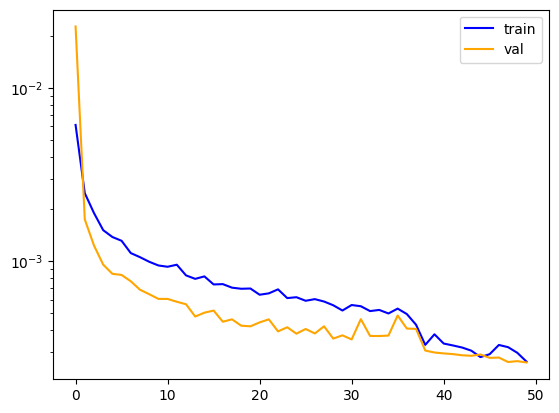

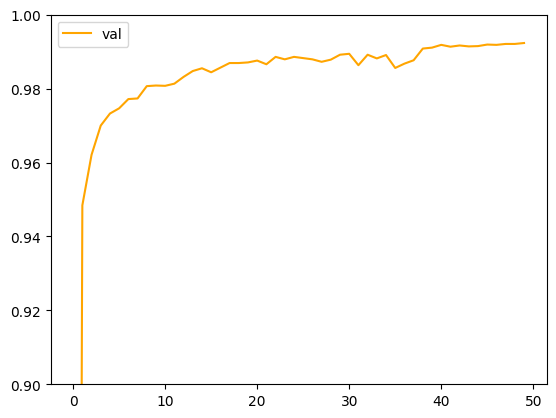

In [8]:
# plot em all
# print mins
print("min val loss:", min(val_losses))
print("min train loss:", min(train_losses))
print("max val acc:", max(val_accs))
plt.plot(train_losses, label="train", color="blue")
plt.plot(val_losses, label="val", color="orange")
plt.legend()
plt.yscale("log")
plt.show()

plt.plot(val_accs, label="val", color="orange")
plt.legend()
plt.ylim(0.90, 1.0)
plt.show()